In [23]:
import tkinter as tk
from tkinter import filedialog
import numpy as np  
import matplotlib.pyplot as plt
import cv2 
from scipy import ndimage
from skimage import filters ,color


In [24]:
def select_images():
    root = tk.Tk()
    root.wm_attributes('-topmost', 1)
    root.withdraw()

    file_paths = filedialog.askopenfilenames(title="Select Image Files", filetypes=[("Image files", "*.jpg;*.jpeg;*.png;*.gif;*.tif;")])
    if file_paths:
        image = cv2.imread(file_paths[0])
        image = cv2.resize(image, (640, 480))
    return image

In [25]:
def img_plot(img,title = 'img'):
    plt.figure(figsize=(8,6))
    plt.imshow((img), cmap=plt.cm.gray)
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    plt.title(title)  
    plt.show()

In [26]:
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_RBUTTONUP:
        cv2.destroyAllWindows()
def BGRtoHSV(BGR):
    hsv = cv2.cvtColor(BGR, cv2.COLOR_BGR2HSV)
    return cv2.split(hsv)
def HSVtoBGR(H,S,V):
    hsv = np.stack([H,S,V],axis=2)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return bgr

In [27]:
def denoise_tv(image, weight=1/90, eps=1.e-5, max_num_iter=200):
    """Perform total-variation denoising on n-dimensional images.
    
    Parameters
    ----------
    image : ndarray
        n-D input data to be denoised.
    weight : float, optional
        Denoising weight It is equal to 1/lambda . The greater `weight`, the more denoising (at
        the expense of fidelity to `input`).
        
    eps : float, optional
        Relative difference of the value of the cost function that determines
        the stop criterion. The algorithm stops when:

            (E_(n-1) - E_n) < eps * E_0
        where E_0 is the initial value of the cost function.    

    max_num_iter : int, optional
        Maximal number of iterations used for the optimization.

    Returns
    -------
    out : ndarray
        Denoised array of floats.

    Notes
    -----
    Rudin, Osher and Fatemi algorithm.
    """
    image = image.astype(np.float64)
    ndim = image.ndim
    p = np.zeros((image.ndim, ) + image.shape, dtype=image.dtype)
    g = np.zeros_like(p)
    d = np.zeros_like(image)
    i = 0
    while i < max_num_iter:
        if i > 0:
            # d will be the (negative) divergence of p
            d = -p.sum(0)
            slices_d = [slice(None), ] * ndim
            slices_p = [slice(None), ] * (ndim + 1)
            for ax in range(ndim):
                slices_d[ax] = slice(1, None)
                slices_p[ax+1] = slice(0, -1)
                slices_p[0] = ax
                d[tuple(slices_d)] += p[tuple(slices_p)]
                slices_d[ax] = slice(None)
                slices_p[ax+1] = slice(None)
            out = image + d
        else:
            out = image
        E = (d ** 2).sum()

        # g stores the gradients of out along each axis
        # e.g. g[0] is the first order finite difference along axis 0
        slices_g = [slice(None), ] * (ndim + 1)
        for ax in range(ndim):
            slices_g[ax+1] = slice(0, -1)
            slices_g[0] = ax
            g[tuple(slices_g)] = np.diff(out, axis=ax)
            slices_g[ax+1] = slice(None)

        norm = np.sqrt((g ** 2).sum(axis=0))[np.newaxis, ...]
        E += weight * norm.sum()
        tau = 1. / (2.*ndim)
        norm *= tau / weight
        norm += 1.
        p -= tau * g
        p /= norm
        E /= float(image.size)
        if i == 0:
            E_init = E
            E_previous = E
        else:
            if np.abs(E_previous - E) < eps * E_init:
                break
            else:
                E_previous = E
        i += 1
    print(i,tau)    
    return out.astype(np.uint8)

In [28]:
def adaptive_gamma_transform(img, m):
    """
    Applies adaptive gamma transform on a given image.

    Args:
        img: A grayscale image to be processed.
        m: Size of the local area (height).
        n: Size of the local area (width).

    Returns:
        A gamma corrected image.
    """
    mh = m//2
    rows, cols = img.shape
    gamma_corrected = np.zeros((rows, cols))
    img = (img+1.)/255.
    for i in range(rows):
        for j in range(cols):
            # Calculate the indices for the local area.
            rmin = max(0, i - mh)
            rmax = min(rows, i + mh + 1)
            cmin = max(0, j - mh)
            cmax = min(cols, j + mh + 1)

            # Calculate the average and variance of the local area.
            local_area = img[rmin:rmax, cmin:cmax]
            N = np.mean(local_area)
            b = np.var(local_area)

            # Calculate the gamma value.
            gamma = N/img[i,j] + b

            # Gamma correct the pixel value.
            pixel_value = img[i,j]
            gamma_corrected[i,j] = np.power(pixel_value, gamma)

    return (gamma_corrected*255).astype(np.uint8)

In [29]:
#MSR
def get_ksize(sigma):
    # opencv calculates ksize from sigma as
    # sigma = 0.3*((ksize-1)*0.5 - 1) + 0.8
    # then ksize from sigma is
    # ksize = ((sigma - 0.8)/0.15) + 2.0

    return int(((sigma - 0.8)/0.15) + 2.0)

def get_gaussian_blur(img, ksize=0, sigma=5):
    # if ksize == 0, then compute ksize from sigma
    if ksize == 0:
        ksize = get_ksize(sigma)
    
    # Gaussian 2D-kernel can be seperable into 2-orthogonal vectors
    # then compute full kernel by taking outer product or simply mul(V, V.T)
    sep_k = cv2.getGaussianKernel(ksize, sigma)

    # if ksize >= 11, then convolution is computed by applying fourier transform
    return cv2.filter2D(img, -1, np.outer(sep_k, sep_k))

def ssr(img, sigma):
    # Single-scale retinex of an image
    # SSR(x, y) = log(I(x, y)) - log(I(x, y)*F(x, y))
    # F = surrounding function, here Gaussian
    
    return np.log10(img) - np.log10(get_gaussian_blur(img, ksize=0, sigma=sigma) + 1.0)

def msr(img, sigma_scales=[15, 80, 250]):
    # Multi-scale retinex of an image
    # MSR(x,y) = sum(weight[i]*SSR(x,y, scale[i])), i = {1..n} scales
    img = img + 1.0
    msr = np.zeros(img.shape)
    # for each sigma scale compute SSR
    for sigma in sigma_scales:
        msr += ssr(img, sigma)
    
    # divide MSR by weights of each scale
    # here we use equal weights
    msr = msr / len(sigma_scales)
    
    # computed MSR could be in range [-k, +l], k and l could be any real value
    # so normalize the MSR image values in range [0, 255]
    msr = cv2.normalize(msr, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
    
    return msr

In [30]:
def tanh(img, sigma):

    return np.tanh(img/get_gaussian_blur(img, ksize=0, sigma=sigma))

def mtanh(img, sigma_scales=[15, 80, 250]):
    # Multi-scale tanh
    img = img + 1.0
    i_t = np.zeros(img.shape)
    # for each sigma scale compute tanh
    for sigma in sigma_scales:
        i_t += tanh(img, sigma)
    
    # divide tanh by weights of each scale
    # here we use equal weights
    i_t = i_t / len(sigma_scales)
    
    return (i_t*255).astype(np.uint8)

In [31]:
def DFIE(img , sigma=[10,40,300],m = 3):
    i_l = msr(img,sigma).astype(np.float32) # calculate  weighted MSR
    i_t = mtanh(img,sigma).astype(np.float32) # calculate  weighted tanh
    
    # Using gausian to estimate mean , much faster
    i_l_mean = cv2.blur(i_l, (m, m))
    i_t_mean = cv2.blur(i_t, (m, m))
    alpha = i_t_mean/i_l_mean
    balanced = alpha*i_t + (1-alpha)*i_l

    # mh = m//2
    # rows, cols = img.shape
    # balanced = np.zeros((rows, cols))
    # for i in range(rows):
    #     for j in range(cols):
    #         # Calculate the indices for the local area.
    #         rmin = max(0, i - mh)
    #         rmax = min(rows, i + mh + 1)
    #         cmin = max(0, j - mh)
    #         cmax = min(cols, j + mh + 1)
            
    #         alpha = np.mean(i_t[rmin:rmax, cmin:cmax])/np.mean(i_l[rmin:rmax, cmin:cmax])
    #         balanced[i,j] = alpha*i_t[i,j]+(1-alpha)*i_l[i,j]

    return cv2.normalize(balanced, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)

In [81]:
Img =select_images()
h,s,v = BGRtoHSV(Img)

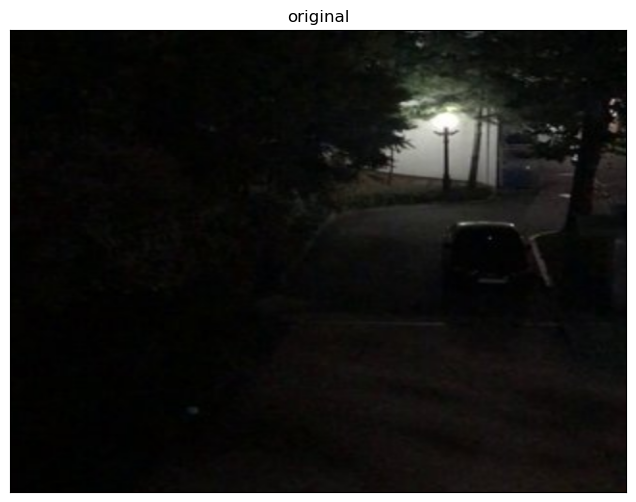

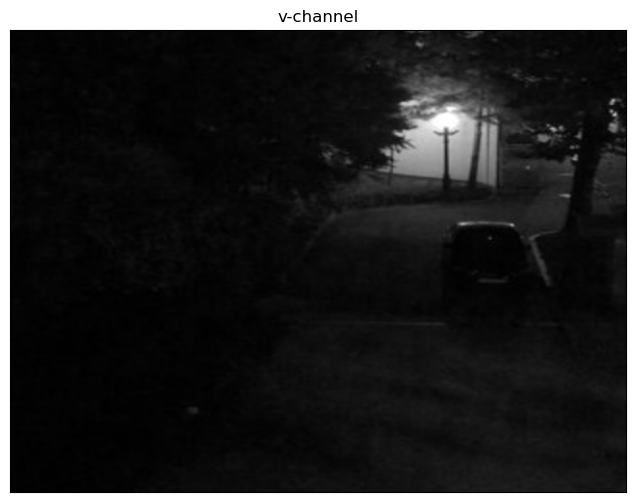

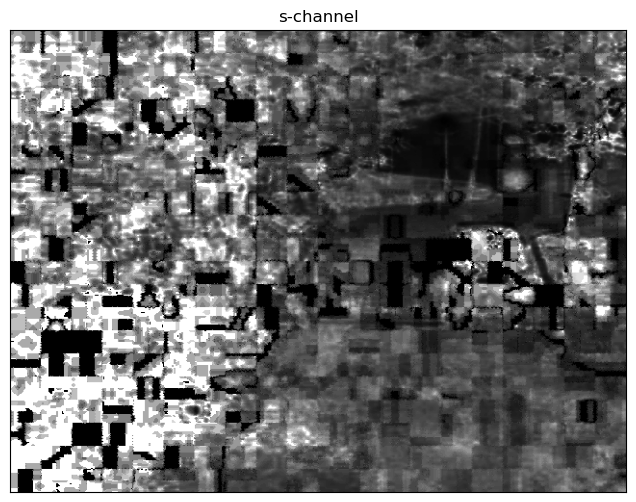

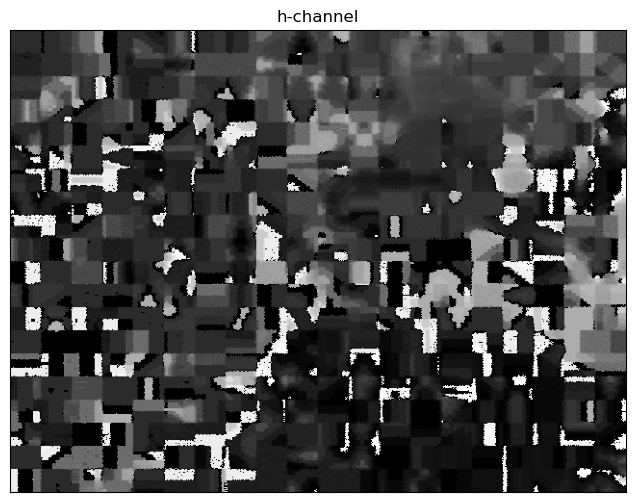

In [82]:
img_plot(np.stack([Img[:,:,2],Img[:,:,1],Img[:,:,0]],axis=2),'original')
img_plot(v,'v-channel')
img_plot(s,'s-channel')
img_plot(h,'h-channel')

In [83]:
cv2.imshow('f', v/255)
cv2.setMouseCallback('f', mouse_callback)  
cv2.waitKey(0)
cv2.destroyAllWindows()
print(h.min() ,h.max())
print(s.min() ,s.max())
print(v.min() ,v.max())

0 177
0 255
0 255


200 0.25


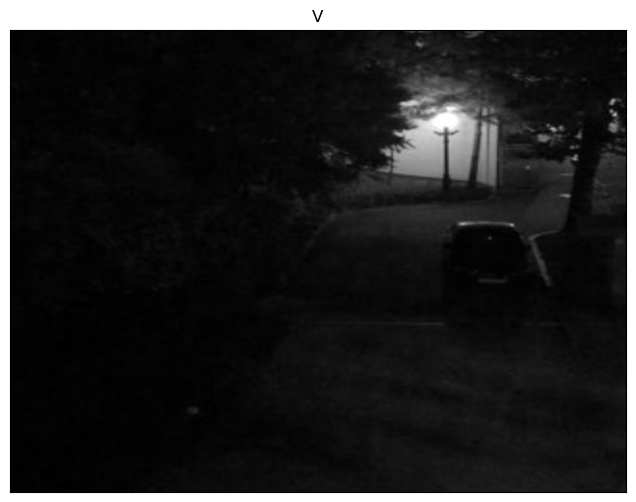

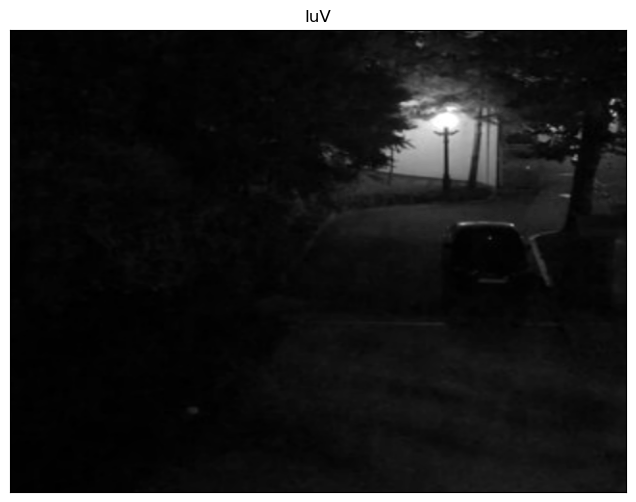

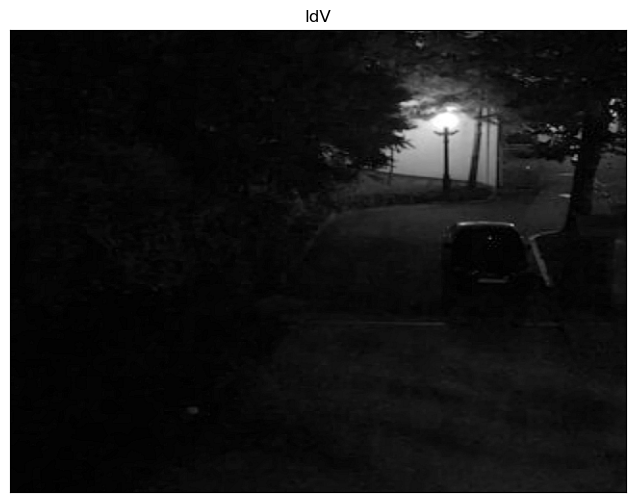

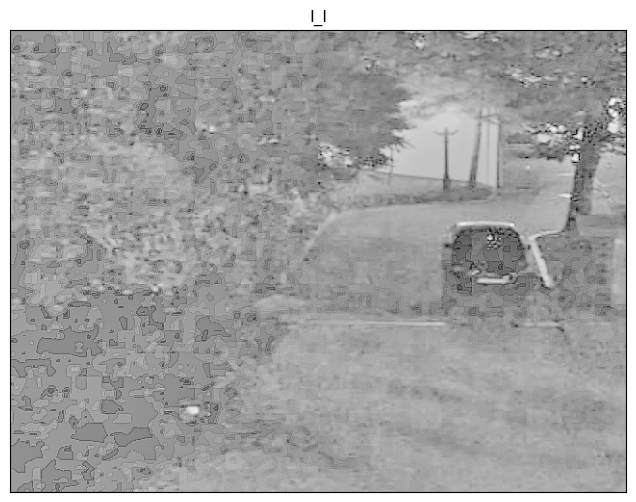

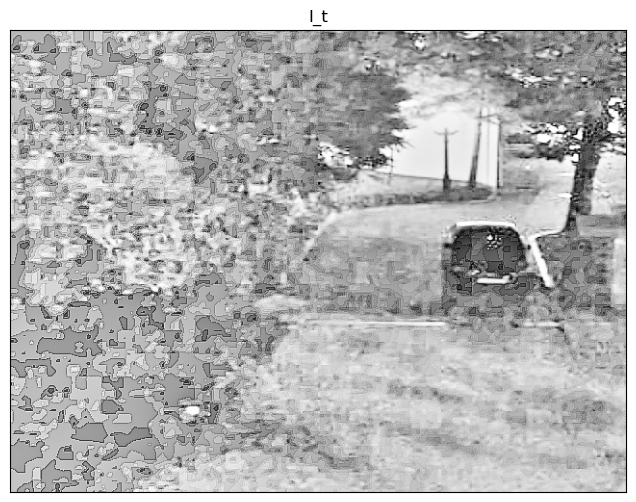

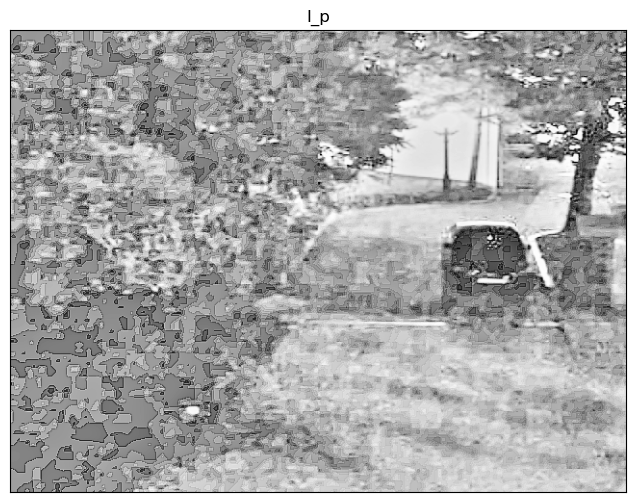

In [112]:
I_u_V= denoise_tv(v, weight=1/10, eps=1e-8, max_num_iter=200)
img_plot(v,'V')
img_plot(I_u_V,'IuV')
I_d_V=adaptive_gamma_transform(I_u_V,3)
img_plot(I_d_V,'IdV')
i_l = msr(I_d_V,[10,40,100])
img_plot(i_l,'I_l')
i_t = mtanh(I_d_V,[10,40,100])
img_plot(i_t,'I_t')
I_p = DFIE(I_d_V , sigma=[10,40,300],m = 5)
img_plot(I_p,'I_p')

In [40]:
def adaptive_saturation_adjustment(s_channel):
    """
    Perform adaptive saturation adjustment on the S channel of an image.
    :param s_channel: The S channel of the image, with pixel values between 0 and 1.
    :return: The adjusted S channel, with pixel values between 0 and 1.
    """
    
    # Calculate the mean and standard deviation of the S channel.
    mean_s = np.mean(s_channel)
    std_s = np.std(s_channel)
    
    # Define the minimum and maximum S values.
    min_s = max(mean_s - std_s, 0)
    max_s = min(mean_s + std_s, 1)
    
    # Adjust the S channel using a linear transform to stretch the values to the full range.
    adjusted_s = (s_channel - min_s) / (max_s - min_s)
    
    return adjusted_s.astype(np.uint8)

In [35]:
def adaptive_saturation_adjustment(s_channel,m):
    s_channel= (s_channel+ 1.)/255.
    rows, cols = s_channel.shape
    saturation_corrected = np.zeros((rows, cols))
    mh = m // 2

    # Get x-gradient in "sx"
    sx = ndimage.sobel(s_channel,axis=0)
    # Get y-gradient in "sy"
    sy = ndimage.sobel(s_channel,axis=1)
    # Get square root of sum of squares

    Sg=np.hypot(sx,sy)
    
    # # Compute the global mean value of the S channel
    S_mean = np.mean(s_channel)
    for i in range(rows):
        for j in range(cols):
            # Calculate the indices for the local area.
            rmin = max(0, i - mh)
            rmax = min(rows, i + mh + 1)
            cmin = max(0, j - mh)
            cmax = min(cols, j + mh + 1)

            # Calculate the average and variance of the local area.
            Sm = np.mean(s_channel[rmin:rmax, cmin:cmax])

            # Apply regulation
            if s_channel[i,j] <= S_mean+Sg[i,j]:
                saturation_corrected[i,j] = 1+0.8*np.log10(((Sm)/(s_channel[i,j]+0.5*Sg[i,j])))   
            else:
                saturation_corrected[i,j] = np.exp((Sm-s_channel[i,j])/2)
    # n=m
    # S_mean = np.mean(s_channel)
    # Sm = cv2.blur(s_channel, (m, n))
    # gx = cv2.Sobel(s_channel, cv2.CV_32F, 1, 0, ksize=3)
    # gy = cv2.Sobel(s_channel, cv2.CV_32F, 0, 1, ksize=3)
    # Sg= np.hypot(gx,gy)
    # for i in range(rows):
    #     for j in range(cols):
    #         if s_channel[i,j] <= S_mean+Sg[i,j]:
    #              saturation_corrected[i,j] = 1+0.8*np.log(((Sm[i,j])/(s_channel[i,j]+0.5*Sg[i,j])))   
    #         else:
    #              saturation_corrected[i,j] = np.exp((Sm[i,j]-s_channel[i,j])/2)     
          
    # # print(np.max(Sg-Sg_1))
    return  (saturation_corrected*255).astype(np.uint8)

In [179]:
I_u_S

array([[5.04685759e-20, 1.24910939e-19, 4.09328388e-19, ...,
        1.40065999e-05, 1.46799082e-05, 1.50355786e-05],
       [1.17051596e-19, 1.85191014e-19, 5.30540028e-19, ...,
        1.59298023e-05, 1.67222103e-05, 1.71127678e-05],
       [3.72343160e-19, 5.52264470e-19, 8.46883847e-19, ...,
        1.99164110e-05, 2.08487417e-05, 2.13633966e-05],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.87400809e-26, 4.68175896e-27, 5.45801550e-28],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.82275775e-26, 3.43839839e-27, 7.70180207e-28],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.43358881e-26, 4.27577253e-27, 6.82155858e-28]])

In [177]:
s.max()


255

88 0.25


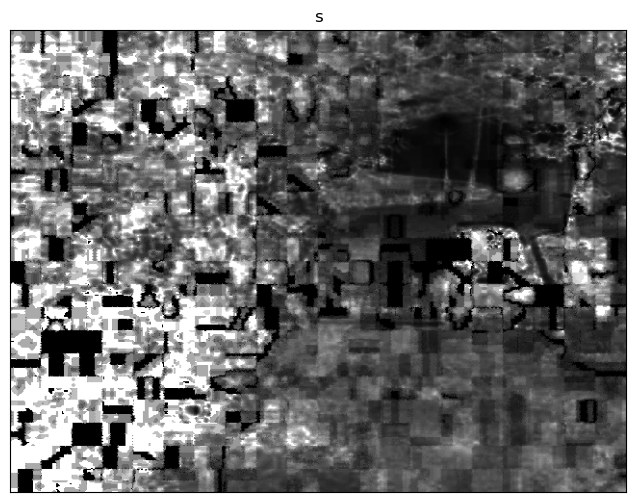

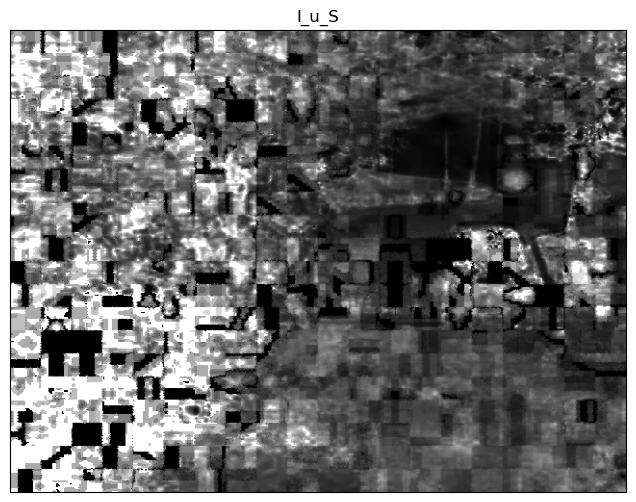

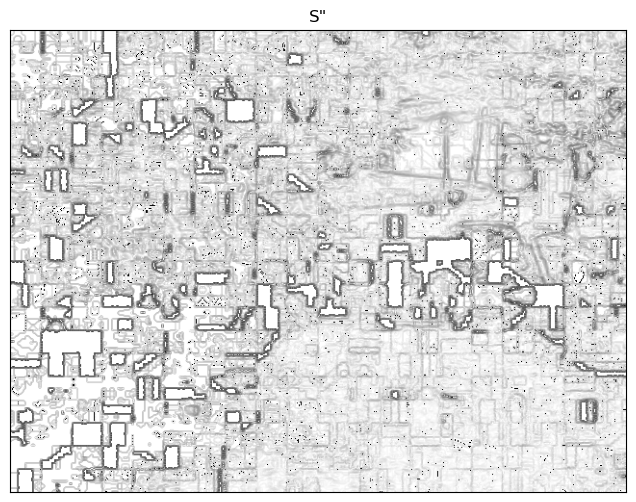

In [85]:
I_u_S= denoise_tv(s, weight=1/90, eps=1e-8, max_num_iter=200)
img_plot(s,'s')
img_plot(I_u_S,'I_u_S')
S_tag = adaptive_saturation_adjustment(I_u_S,3)
img_plot(S_tag,'S"')

In [116]:
(MSR-v)

array([[162, 166, 172, ..., 168, 175, 115],
       [166, 171, 171, ..., 141, 175, 164],
       [129, 129, 140, ..., 142, 173, 163],
       ...,
       [163, 163, 157, ..., 122, 164, 164],
       [114, 114, 114, ..., 123, 133, 122],
       [114, 114, 115, ..., 123, 134, 133]], dtype=uint8)

In [167]:
cv2.imshow('f', (I_p-v))
cv2.setMouseCallback('f', mouse_callback)  
cv2.waitKey(0)
cv2.destroyAllWindows()

In [101]:
cv2.imshow('f',np.concatenate([HSVtoBGR(h,s,i_t),HSVtoBGR(h,s,i_l),HSVtoBGR(h,s,I_p)],axis=1))
cv2.setMouseCallback('f', mouse_callback)  
cv2.waitKey(0)
cv2.destroyAllWindows()

In [114]:

cv2.imshow('f', np.concatenate([HSVtoBGR(h,I_u_S,I_p),HSVtoBGR(h,s,I_p),Img],axis=1))
cv2.setMouseCallback('f', mouse_callback)  
cv2.waitKey(0)
cv2.destroyAllWindows()


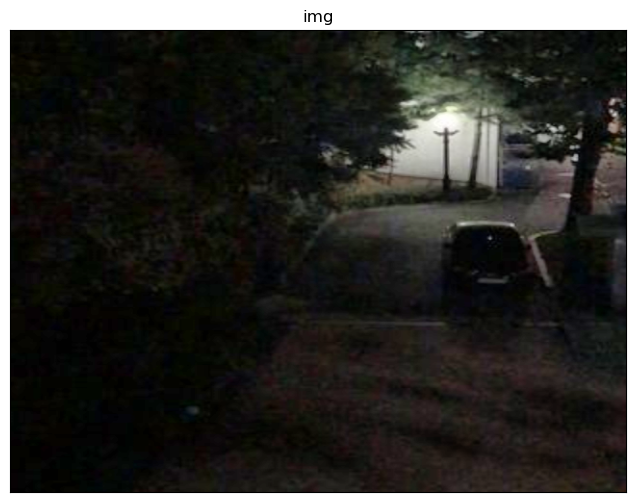

In [113]:

import skimage
I = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)
eq = skimage.exposure.equalize_adapthist(I)
img_plot(eq)

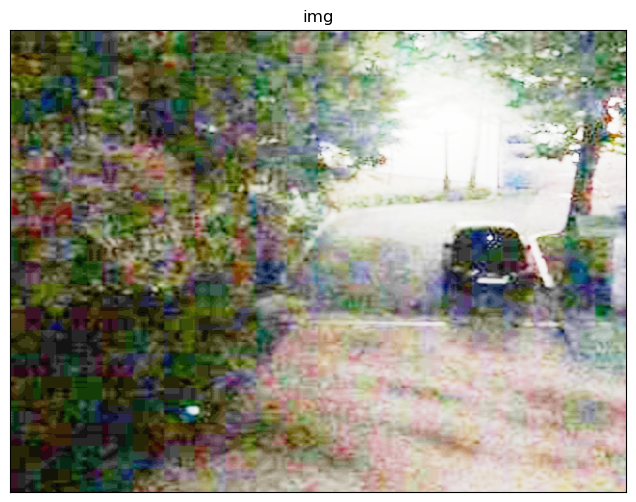

In [115]:

dst = skimage.exposure.equalize_hist(I)
img_plot(dst)
